# Dirección de Riesgos: Contención Oportuna

## Caso de Estudio: Banco de Taiwan

## Definición del problema real

La Dirección de Riesgos del Banco de Taiwan generó recientemente una alerta sobre el incremento sostenido de los indicadores de cartera, especialmente en el producto de tarjetas de crédito, pasando del 6.66% al 8.93%.

Desde el departamento de Inteligencia de Negocios y Analítica se desarrolla un proyecto para contener a los clientes en etapas de mora tempranas, identificando oportunamente el momento en que estos empezarán a caer en mora y desarrollando estrategias que le faciliten a los clientes los pagos de sus obligaciones.

El objetivo del proyecto es construir una herramienta que permita al Banco de Taiwan identificar a estos clientes antes de que caigan en mora. 

* Como criterio de éxito desde el negocio, se espera que de cada 100 clientes identificados y contactados, se logre evitar que 80 de ellos caigan en mora.
* Como criterio de éxito desde la minería de datos, se espera una sensibilidad de más del 75%. Esto debido a la importancia de ser capaz de identificar a la mayoría de clientes que realmente caerán en mora.

## Definición del problema en términos de los datos

Los datos utilizados para el proyecto provienen de [default of credit card clients Data Set ](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

Este conjunto de datos contiene 30.000 clientes definidos por 24 variables, explicadas a continuación:

* Valor del crédito, en dólares taiwaneses
* Género (1 = Masculino; 2 = Femenino)
* Nivel educativo (1 = Posgrado; 2 = Universitario; 3 = Bachillerato; 4 = Otros)
* Estado civil (1 = Casado; 2 = Soltero; 3 = Otros)
* Edad, en años.
* 6 valores que representan el comportamiento de pago del cliente. Corresponde al período comprendido entre Abril (X11) y Septiembre de 2005 (X6). Es una variable cualitativa. (-1 = Pago a tiempo; 0 = Pago durante el mes; 1 = Pago retrasado 1 mes; 2 = Pago retrasado 2 meses; ... ; 9 = Pago retrasado 9 o más meses)
* 6 valores que representan los valores de factura en los mismos períodos representados anteriormente
* 6 valores que representan los valores pagados en los mismos períodos representados anteriormente
* Variable binaria que indica si el cliente cae en mora al siguiente mes (1 = Si; 0 = No)

El problema presentado es un problema de clasificación binaria. Se realizará una exploración inicial de los datos para luego pasar a la fase de modelamiento.

Para la modelación se separará el conjunto de datos en dos:

* Conjunto A: se seleccionará aleatoriamente el 70% de las observaciones. Estas a su vez serán utilizadas en la validación cruzada de cada modelo para selecionar la mejor combinación de hiperparámetros de cada modelo.
* Conjunto B: es el 30% de los datos restantes. Los modelos nunca conocerán estos datos, y estos serán utilizados para estimar el error real de los modelos en un ambiente productivo. Con las métricas de error pronosticadas por este conjunto es que se seleccionará el modelo final.

## Exploración

In [29]:
#Carga de los datos
#install.packages('readxl')
require(readxl)

#Se realiza la importación del archivo .xls. La primera fila se omite ya que en la segunda empiezan los encabezados.
cc_data <- read_xls(path = 'default of credit card clients.xls', skip = 1)

In [30]:
#Se realiza un renombramiento de las columnas para hacerlas más fáciles de trabajar
colnames(cc_data) <- c("id", "valor.credito", "genero", "nivel.educativo", "estado.civil", "edad",
                       "pago.sep", "pago.ago", "pago.jul", "pago.jun", "pago.may", "pago.abr",
                       "factura.sep", "factura.ago", "factura.jul", "factura.jun", "factura.may", "factura.abr",
                       "pagado.sep", "pagado.ago", "pagado.jul", "pagado.jun", "pagado.may", "pagado.abr", "default")

In [31]:
#Revisión de la proporción de casos de default: 22.12%
print("Tabla de Proporciones: Clientes en Default (0: al día; 1: en default)")
round(prop.table(table(cc_data$default))*100, 2)

#Resumen general de las variables
print("Resumen general de las variables")
summary(cc_data)

#Importación de paquetes para el análisis exploratorio
require(dplyr)
require(ggplot2)
require(moments)
options(repr.plot.width = 4, repr.plot.height = 3)

[1] "Tabla de Proporciones: Clientes en Default (0: al día; 1: en default)"



    0     1 
77.88 22.12 

[1] "Resumen general de las variables"


       id        valor.credito         genero      nivel.educativo
 Min.   :    1   Min.   :  10000   Min.   :1.000   Min.   :0.000  
 1st Qu.: 7501   1st Qu.:  50000   1st Qu.:1.000   1st Qu.:1.000  
 Median :15000   Median : 140000   Median :2.000   Median :2.000  
 Mean   :15000   Mean   : 167484   Mean   :1.604   Mean   :1.853  
 3rd Qu.:22500   3rd Qu.: 240000   3rd Qu.:2.000   3rd Qu.:2.000  
 Max.   :30000   Max.   :1000000   Max.   :2.000   Max.   :6.000  
  estado.civil        edad          pago.sep          pago.ago      
 Min.   :0.000   Min.   :21.00   Min.   :-2.0000   Min.   :-2.0000  
 1st Qu.:1.000   1st Qu.:28.00   1st Qu.:-1.0000   1st Qu.:-1.0000  
 Median :2.000   Median :34.00   Median : 0.0000   Median : 0.0000  
 Mean   :1.552   Mean   :35.49   Mean   :-0.0167   Mean   :-0.1338  
 3rd Qu.:2.000   3rd Qu.:41.00   3rd Qu.: 0.0000   3rd Qu.: 0.0000  
 Max.   :3.000   Max.   :79.00   Max.   : 8.0000   Max.   : 8.0000  
    pago.jul          pago.jun          pago.may

[1] "Asimetría:"


[1] 0.9928173

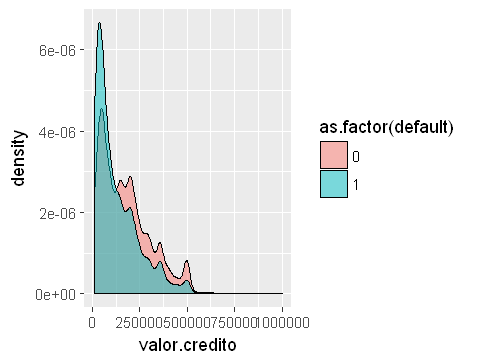

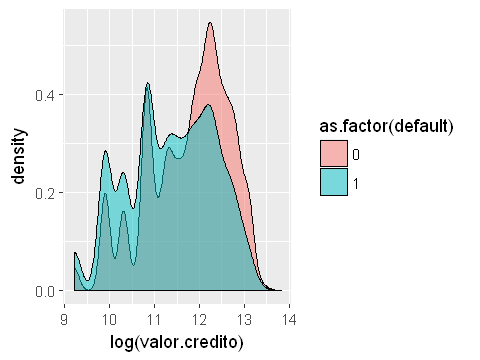

In [32]:
#Análisis del valor del crédito
print("Asimetría:")
skewness(cc_data$valor.credito)
ggplot(cc_data, aes(x = valor.credito, fill = as.factor(default))) + geom_density(alpha = .5)
ggplot(cc_data, aes(x = log(valor.credito), fill = as.factor(default))) + geom_density(alpha = .5)

#El valor del crédito muestra una leve asimetría la cual podría corregirse mediante una transformación logarítmica
cc_data <- mutate(cc_data, log.valor.credito = log(valor.credito))

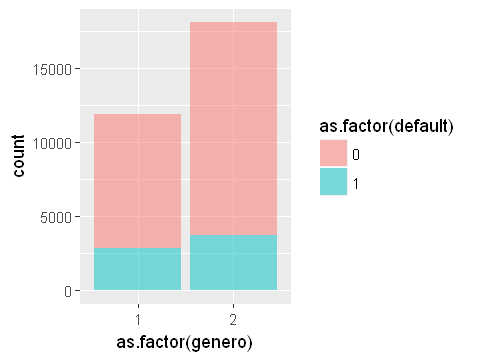

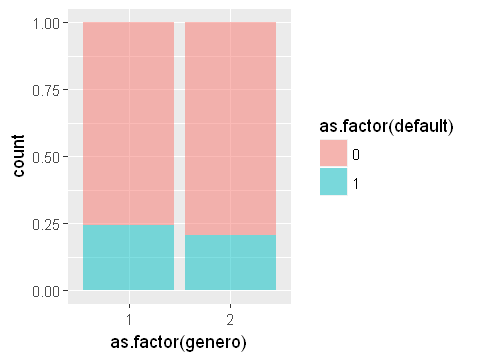

In [33]:
#Análisis del género
ggplot(cc_data, aes(x = as.factor(genero), fill = as.factor(default))) + geom_bar(alpha = .5)
ggplot(cc_data, aes(x = as.factor(genero), fill = as.factor(default))) + geom_bar(alpha = .5, position = 'fill')

#Hay más mujeres que hombres. Parece que los hombres pagan mejor, pero no parece existir una diferencia significativa.

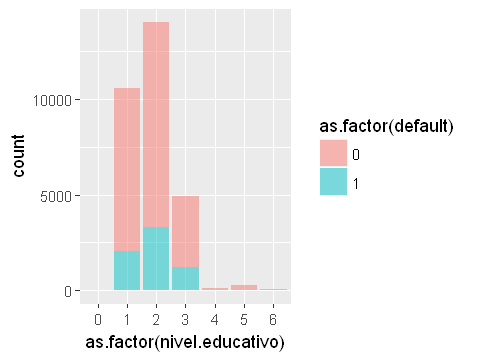

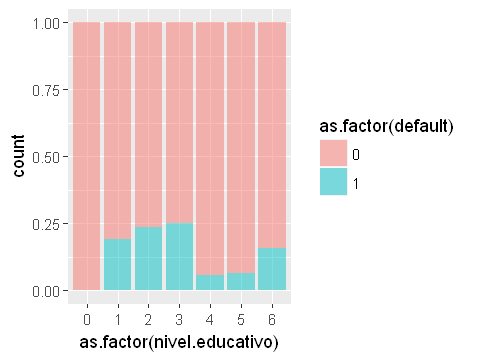

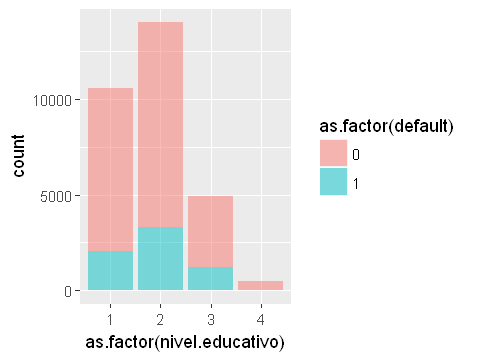

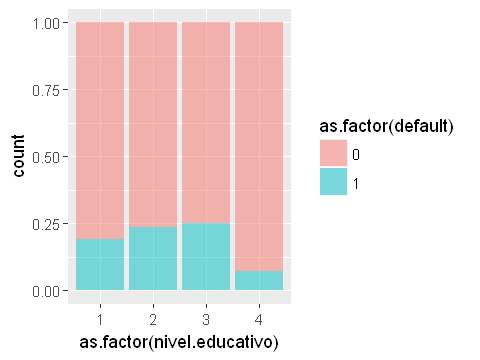

In [34]:
#Análisis del nivel educativo
ggplot(cc_data, aes(x = as.factor(nivel.educativo), fill = as.factor(default))) + geom_bar(alpha = .5)
ggplot(cc_data, aes(x = as.factor(nivel.educativo), fill = as.factor(default))) + geom_bar(alpha = .5, position = 'fill')

#Las categorías 0, 5 y 6 no están definidas en la base de datos, se agruparán dentro de la categoría 4 - Otros
cc_data <- mutate(cc_data, nivel.educativo = ifelse(nivel.educativo %in% c(0, 5, 6), 4, nivel.educativo))

#Se visualiza la distribución de la variable mutada
ggplot(cc_data, aes(x = as.factor(nivel.educativo), fill = as.factor(default))) + geom_bar(alpha = .5)
ggplot(cc_data, aes(x = as.factor(nivel.educativo), fill = as.factor(default))) + geom_bar(alpha = .5, position = 'fill')

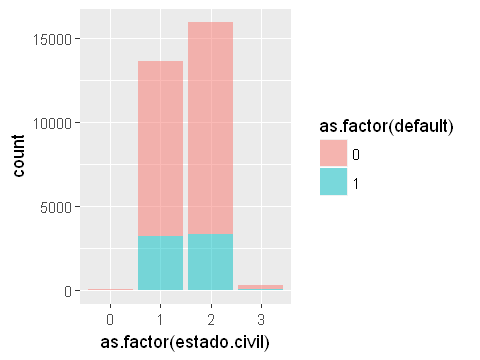

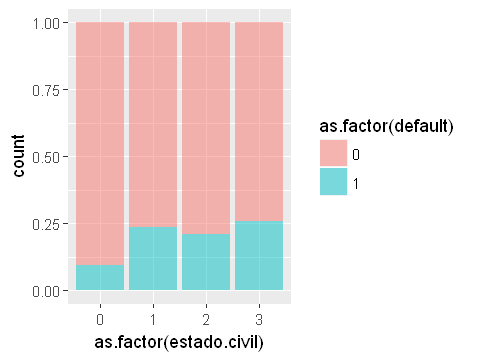

In [35]:
#Análisis del estado civil
ggplot(cc_data, aes(x = as.factor(estado.civil), fill = as.factor(default))) + geom_bar(alpha = .5)
ggplot(cc_data, aes(x = as.factor(estado.civil), fill = as.factor(default))) + geom_bar(alpha = .5, position = 'fill')

#La categoría 0 del estado civil no está definida en la descripción de la base de datos. Se agrupan en la categoría 3 - Otros.
cc_data <- mutate(cc_data, estado.civil = ifelse(estado.civil == 0, 3, estado.civil))

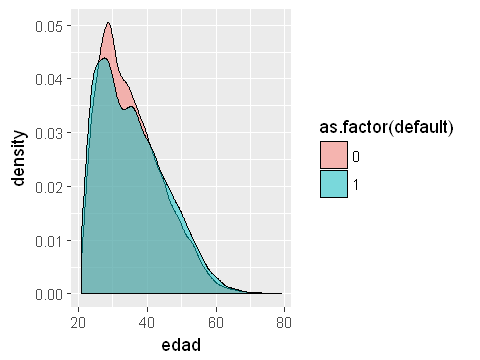

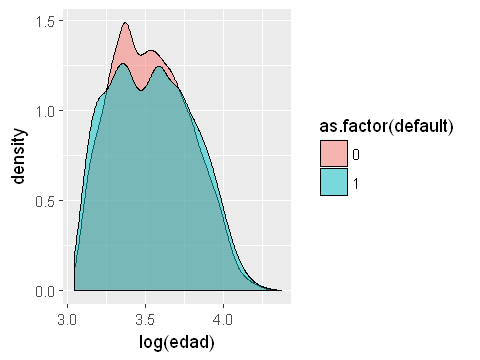

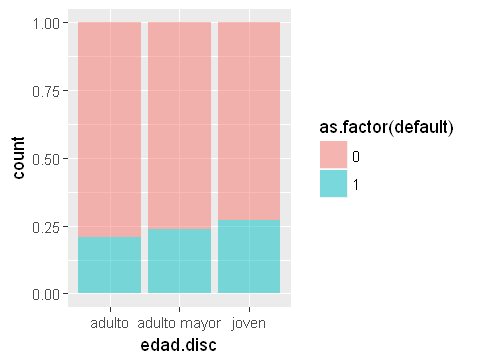

In [79]:
#Análisis de la edad
ggplot(cc_data, aes(x = edad, fill = as.factor(default))) + geom_density(alpha = .5)
ggplot(cc_data, aes(x = log(edad), fill = as.factor(default))) + geom_density(alpha = .5)

#Se evidencia que hay una porción de la edad que tiene un peor cumplimiento.
#Se propone dentro del preprocesamiento hacer una discretización de la variable en 3 categorías:
#Joven: < 25; Adulto: 25 - 40; Adulto Mayor: > 40
cc_data <- mutate(cc_data, edad.disc = factor(case_when(edad < 25 ~ 'joven',
                                                        between(edad, 25, 40) ~ 'adulto',
                                                        edad > 40 ~ 'adulto mayor')))

ggplot(cc_data, aes(x = edad.disc, fill = as.factor(default))) + geom_bar(alpha = .5, position = 'fill')

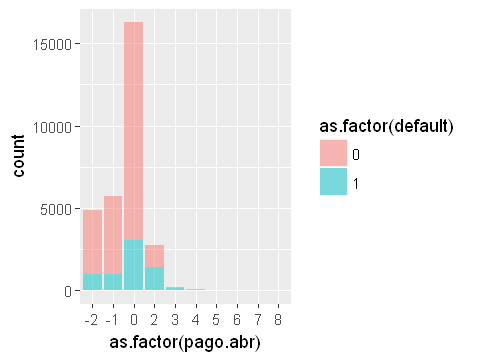

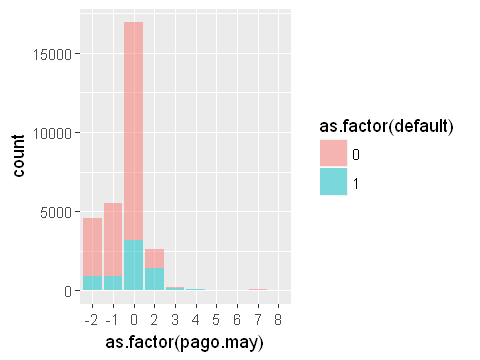

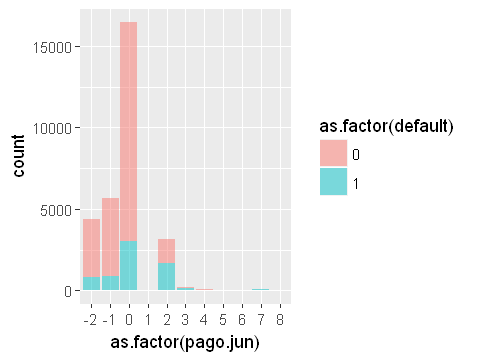

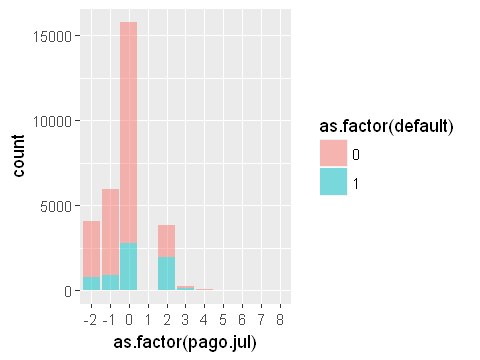

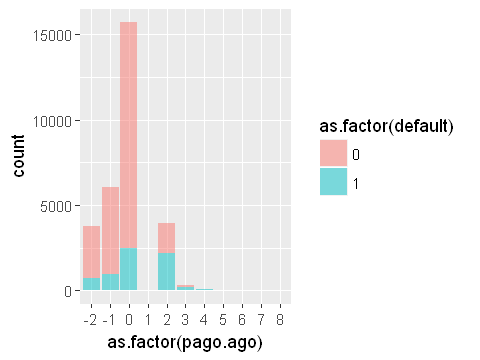

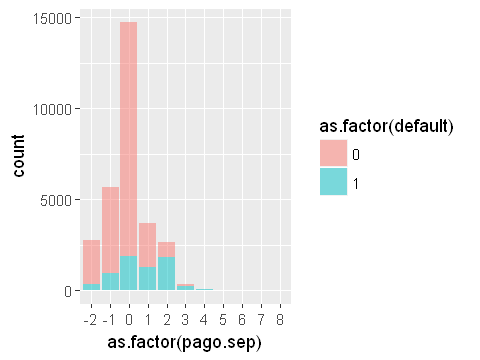

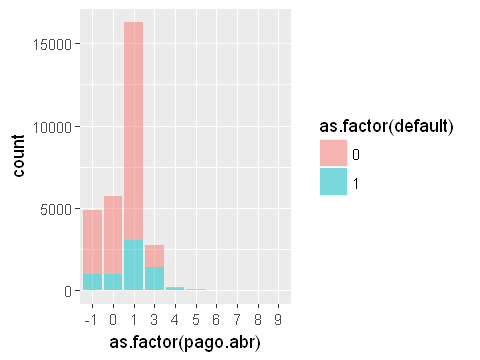

In [39]:
#Análisis de las variables del comportamiento de pago
ggplot(cc_data, aes(x = as.factor(pago.abr), fill = as.factor(default))) + geom_bar(alpha = .5)
ggplot(cc_data, aes(x = as.factor(pago.may), fill = as.factor(default))) + geom_bar(alpha = .5)
ggplot(cc_data, aes(x = as.factor(pago.jun), fill = as.factor(default))) + geom_bar(alpha = .5)
ggplot(cc_data, aes(x = as.factor(pago.jul), fill = as.factor(default))) + geom_bar(alpha = .5)
ggplot(cc_data, aes(x = as.factor(pago.ago), fill = as.factor(default))) + geom_bar(alpha = .5)
ggplot(cc_data, aes(x = as.factor(pago.sep), fill = as.factor(default))) + geom_bar(alpha = .5)
#La variable de pago para los diferentes meses va desde -2 a 8; mientras que en la definición de pagos se dice que va de
#-1 a 9. Se hará la corrección, sumándole 1 a cada variable.

cc_data <- mutate(cc_data, pago.abr = pago.abr + 1,
                           pago.may = pago.may + 1,
                           pago.jun = pago.jun + 1,
                           pago.jul = pago.jul + 1,
                           pago.ago = pago.ago + 1,
                           pago.sep = pago.sep + 1)

ggplot(cc_data, aes(x = as.factor(pago.abr), fill = as.factor(default))) + geom_bar(alpha = .5)

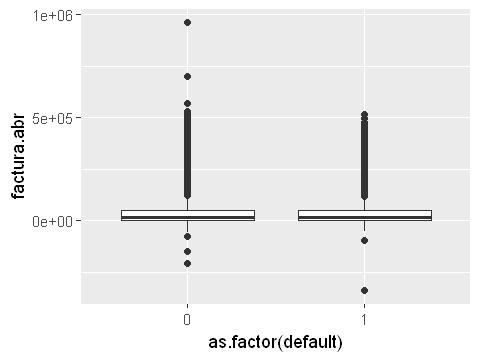

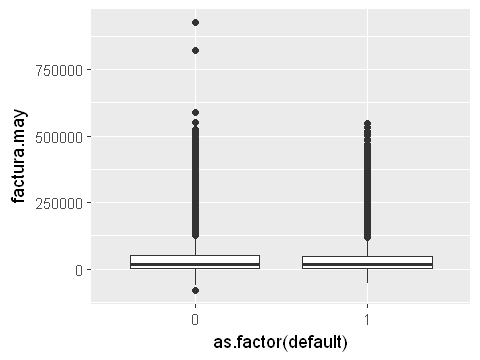

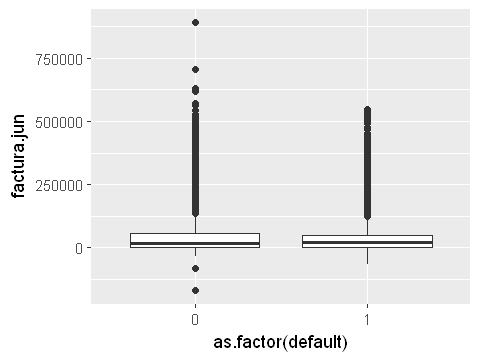

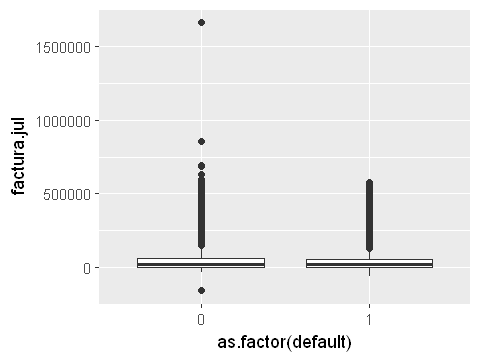

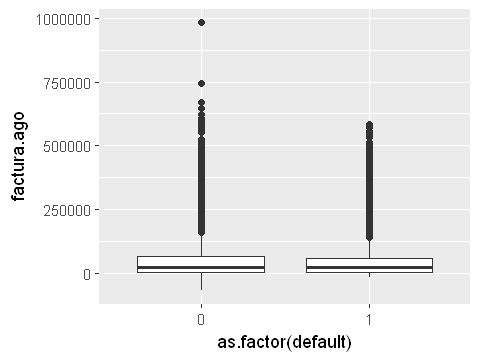

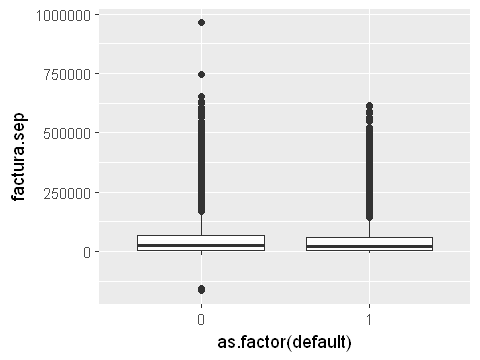

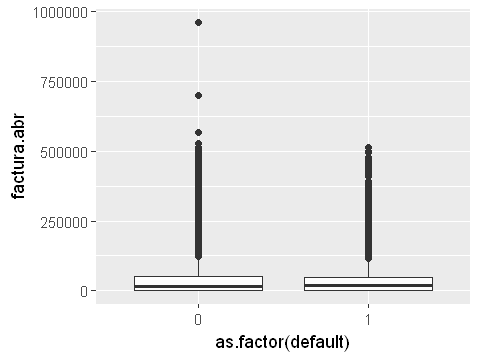

In [40]:
#Análisis de las variables de valor factura
ggplot(cc_data, aes(x = as.factor(default), y = factura.abr)) + geom_boxplot()
ggplot(cc_data, aes(x = as.factor(default), y = factura.may)) + geom_boxplot()
ggplot(cc_data, aes(x = as.factor(default), y = factura.jun)) + geom_boxplot()
ggplot(cc_data, aes(x = as.factor(default), y = factura.jul)) + geom_boxplot()
ggplot(cc_data, aes(x = as.factor(default), y = factura.ago)) + geom_boxplot()
ggplot(cc_data, aes(x = as.factor(default), y = factura.sep)) + geom_boxplot()

#Se observa que en general la distribución de esta variable es asimétrica positivamente y concentrada alrededor de 0.
#También se observan varios valores negativos, los cuales no tienen sentido dentro del contexto del valor de la factura.
#Estos valores negativos se transforman en 0.

cc_data <- mutate(cc_data, factura.abr = ifelse(factura.abr < 0, 0, factura.abr),
                           factura.may = ifelse(factura.may < 0, 0, factura.may),
                           factura.jun = ifelse(factura.jun < 0, 0, factura.jun),
                           factura.jul = ifelse(factura.jul < 0, 0, factura.jul),
                           factura.ago = ifelse(factura.ago < 0, 0, factura.ago),
                           factura.sep = ifelse(factura.sep < 0, 0, factura.sep))

ggplot(cc_data, aes(x = as.factor(default), y = factura.abr)) + geom_boxplot()

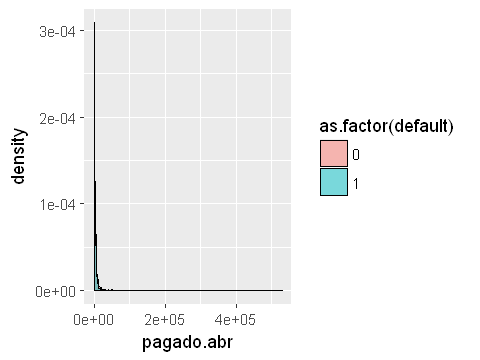

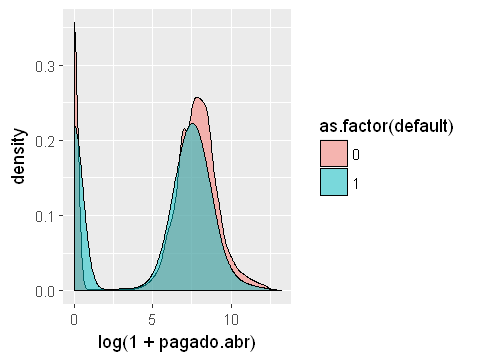

In [52]:
#Análisis de los valores pagados
ggplot(cc_data, aes(x = pagado.abr, fill = as.factor(default))) + geom_density(alpha = .5)
ggplot(cc_data, aes(x = log(1+pagado.abr), fill = as.factor(default))) + geom_density(alpha = .5)

## Metodologías Seleccionadas

Para la modelación se seleccionaron las siguientes metodologías, empezando por las más sencillas y computacionalmente económicas y progresivamente evolucionando hacia las metodologías más complejas. La idea con esta ordenación es conservar un equilibrio entre *precisión* y *complejidad* del modelo, con el objetivo de obtener el modelo más simple que cumpla con los requisitos de precisión mencionados anteriormente.

### 1 - OneR

One-Rule o OneR, es posiblemente el algoritmo de clasificación más sencillo. Su objetivo es consolidar toda la lógica de clasificación en una única regla, fácil de entender e interpretar. El algoritmo de OneR crea la partición de los posibles valores de una única variable que minimiza el error total.

### 2 - Regresión Logística

Hace parte de la familia de modelos lineales generalizados. A cada observación le asigna un puntaje interpretable como la probabilidad de que la observación corresponda a la categoría positiva, en este caso default. El modelo genera una frontera de separación lineal entre las clases.

### 3 - k Vecinos más Cercanos

Este algoritmo identifica los k registros o clientes más similares a cada observación y realiza su voto por mayoría. Si la mayoría de sus "vecinos" cayeron en default, se clasifica como default. Debido a que esta votación se hace por mayoría, es recomendado utilizar una cantidad impar de vecinos.

### 4 - Árboles de Decisión

Los árboles de decisión generan un conjunto de reglas, en forma de una partición rectangular del espacio, para clasificar a los clientes. De esta manera se forman reglas como: "Si es hombre, tiene más de 30 años y el valor pagado en julio fue inferior a 200, entonces el cliente caerá en default".

### 5 - AdaBoost

Es un ensamble de árboles de decisión que utiliza una estrategia de hacer que cada árbol generado se enfoque en corregir los errores de los árboles previos.

### 6 - Máquinas de Vector Soporte con Kernel de Base Radial

Este algoritmo utiliza un kernel que lleva los datos a espacios característicos de más dimensiones y allí genera la separación lineal, la cual puede resultar siendo una separación no lineal en el espacio característico original.

## Aplicación de las Metodologías y Análisis de Resultados

In [85]:
require(caret)

#Creación de los conjuntos A y B para validación cruzada y medición de error, respectivamente.
indexes_A <- sample(1:nrow(cc_data_clean), 0.7 * nrow(cc_data_clean))
setA <- cc_data_clean[indexes_A,]
setB <- cc_data_clean[-indexes_A,]

#Creación de los folds para la validación cruzada. Se crean en este paso para que las particiones sean las mismas para
#todos los modelos.
kFolds <- createFolds(setA$default, k = 10)

#Creación de la función que mide la métrica a utilizar para la selección de los modelos, acorde al caso de negocio
#En este caso, se busca maximizar la sensibilidad sin dejar de lado la precisión, por lo cual usaremos una métrica F3
fB <- function (data, lev = NULL, model = NULL, B = 3) {
  precision <- posPredValue(data$pred, data$obs, positive = "1")
  recall  <- sensitivity(data$pred, data$obs, postive = "1")
  fB_val <- ((1 + B^2) * precision * recall) / (B^2 * precision + recall)
  names(fB_val) <- c("FB")
  return(fB_val)
} 

#Creación del objeto trainControl a ser utilizado en los modelos
control <- trainControl(method = 'cv', 
                        number = 10, 
                        summaryFunction = fB,
                        index = kFolds)

#Función para resumir los valores de interés para comparar modelos
result.summary <- function(model){
    predictions <- predict(model, setB)
    conf_matrix <- round(prop.table(table(predictions, setB$default))*100, 2)
    accuracy <- (conf_matrix[1,1] + conf_matrix[2,2]) / sum(conf_matrix)
    sensitivity <- conf_matrix[2,2] / sum(conf_matrix[,2])
    f3 <- 10 * accuracy * sensitivity / (9 * accuracy + sensitivity)
    return(list(Matrix = conf_matrix, Accuracy = accuracy, Sensitivity = sensitivity, F3_Measure = f3))
}

In [87]:
#One R
model.oner <- train(default ~ log.valor.credito + genero + nivel.educativo + estado.civil + edad.disc + pago.sep + pago.ago + 
                    pago.jul + pago.jun + pago.may + pago.abr + factura.sep + factura.ago + factura.jul + factura.jun + 
                    factura.may + factura.abr + pagado.sep + pagado.ago + pagado.jul + pagado.jun + pagado.may + pagado.abr, 
                    data = setA, 
                    trControl = control, 
                    metric = 'FB',
                    method = 'OneR',
                    preProcess = c('nzv'))

In [88]:
result.summary(model.oner)

#OneR muestra un desempeño sorprendentemente bueno en precisión. Sin embargo, el objetivo principal de este problema es
#maximizar la sensibilidad, que solo da de 0.26. Se utiliza la medida F3 para obtener un balance entre precisión y
#sensibilidad, dándole más peso a la última.

$Matrix
           
predictions     0     1
          0 75.31 16.41
          1  2.43  5.85

$Accuracy
[1] 0.8116

$Sensitivity
[1] 0.2628032

$F3_Measure
[1] 0.2818625


In [89]:
#Regresión Logística
model.logit <- train(default ~ log.valor.credito + genero + nivel.educativo + estado.civil + edad.disc + pago.sep + pago.ago + 
                     pago.jul + pago.jun + pago.may + pago.abr + factura.sep + factura.ago + factura.jul + factura.jun + 
                     factura.may + factura.abr + pagado.sep + pagado.ago + pagado.jul + pagado.jun + pagado.may + pagado.abr, 
                     data = setA, 
                     trControl = control, 
                     metric = 'FB',
                     method = 'glm',
                     family = 'binomial',
                     preProcess = c('nzv'))

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [90]:
result.summary(model.logit)

#La regresión logística muestra una precisión similar a OneR, pero un incremento sustancial en la sensibilidad y en la F3.

$Matrix
           
predictions     0     1
          0 74.43 15.07
          1  3.31  7.19

$Accuracy
[1] 0.8162

$Sensitivity
[1] 0.3230009

$F3_Measure
[1] 0.3437739


In [82]:
#kNN
model.knn <- train(default ~ log.valor.credito + genero + nivel.educativo + estado.civil + edad.disc + pago.sep + pago.ago + 
                   pago.jul + pago.jun + pago.may + pago.abr + factura.sep + factura.ago + factura.jul + factura.jun + 
                   factura.may + factura.abr + pagado.sep + pagado.ago + pagado.jul + pagado.jun + pagado.may + pagado.abr, 
                   data = setA, 
                   trControl = control, 
                   metric = 'FB',
                   method = 'knn',
                   preProcess = c('center', 'scale', 'nzv'),
                   tuneGrid = expand.grid(k = seq(3, 13, by = 2)))

In [91]:
result.summary(model.knn)

#Los resultados de kNN muestran un incremento en la sensibilidad con respecto a lo evaluado en la regresión logística.
#Se observa que los resultados en precisión son muy similares entre los modelos evaluados.
#Hasta ahora, kNN es la mejor alternativa ya que es un modelo relativamente fácil de explicar y ha presentado los mejores resultados.


$Matrix
           
predictions     0     1
          0 73.88 14.12
          1  3.86  8.14

$Accuracy
[1] 0.8202

$Sensitivity
[1] 0.3656783

$F3_Measure
[1] 0.3871316


In [94]:
#Árboles de Decisión
#install.packages('rpart')
model.tree <- train(default ~ log.valor.credito + genero + nivel.educativo + estado.civil + edad.disc + pago.sep + pago.ago + 
                   pago.jul + pago.jun + pago.may + pago.abr + factura.sep + factura.ago + factura.jul + factura.jun + 
                   factura.may + factura.abr + pagado.sep + pagado.ago + pagado.jul + pagado.jun + pagado.may + pagado.abr, 
                   data = setA, 
                   trControl = control, 
                   metric = 'FB',
                   method = 'rpart',
                   preProcess = c('nzv'))

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

In [95]:
result.summary(model.tree)

#El árbol de decisión clasificó todas las observaciones en la categoría 0, indicando que nadie caería en default.
#Esto causó una sensibilidad de 0, lo cual es completamente inaceptable para la compañía, haciendo que este modelo sea inútil.

$Matrix
           
predictions     0     1
          0 77.74 22.26
          1  0.00  0.00

$Accuracy
[1] 0.7774

$Sensitivity
[1] 0

$F3_Measure
[1] 0


In [96]:
#Adaptive Boosting
#install.packages('fastAdaboost')
model.adaboost <- train(default ~ log.valor.credito + genero + nivel.educativo + estado.civil + edad.disc + pago.sep + pago.ago + 
                        pago.jul + pago.jun + pago.may + pago.abr + factura.sep + factura.ago + factura.jul + factura.jun + 
                        factura.may + factura.abr + pagado.sep + pagado.ago + pagado.jul + pagado.jun + pagado.may + pagado.abr, 
                        data = setA, 
                        trControl = control, 
                        metric = 'FB',
                        method = 'adaboost',
                        preProcess = c('nzv'))

Loading required package: fastAdaboost


In [97]:
result.summary(model.adaboost)

#Sorprendentemente, el Adaptive Boosting muestra unos resultados peores a los de los modelos explorados anteriormente, 
#Esto da evidencia de que quizás para este problema en específico los modelos basados en árboles no sean la mejor opción.

$Matrix
           
predictions     0     1
          0 73.76 16.99
          1  3.98  5.27

$Accuracy
[1] 0.7903

$Sensitivity
[1] 0.2367475

$F3_Measure
[1] 0.2545791


In [98]:
#Radial-based Support Vector Machine
model.rbsvm <- train(default ~ log.valor.credito + genero + nivel.educativo + estado.civil + edad.disc + pago.sep + pago.ago + 
                     pago.jul + pago.jun + pago.may + pago.abr + factura.sep + factura.ago + factura.jul + factura.jun + 
                     factura.may + factura.abr + pagado.sep + pagado.ago + pagado.jul + pagado.jun + pagado.may + pagado.abr, 
                     data = setA, 
                     trControl = control, 
                     metric = 'FB',
                     method = 'svmRadial',
                     preProcess = c('nzv'))

Loading required package: kernlab

Attaching package: 'kernlab'

The following object is masked from 'package:ggplot2':

    alpha



In [99]:
result.summary(model.rbsvm)

#Los resultados de la máquina de vector soporte no son lo suficientemente buenos comparados con los resultados de knn.
#Esto indica que la verdadera frontera de separación sea altamente compleja. 
#Es posible que falten más variables para realizar la separación del espacio, por lo cual hasta el momento la conclusión
#será que "hasta aquí llegan los datos".

$Matrix
           
predictions     0     1
          0 74.84 15.31
          1  2.90  6.95

$Accuracy
[1] 0.8179

$Sensitivity
[1] 0.3122192

$F3_Measure
[1] 0.3327948


## Comparación entre Metodologías

Se inició revisando los resultados de **OneR**, para ser utilizados como "benchmark" a la hora de descartar modelos.

Se probó un modelo lineal, la **Regresión Logística**, la cual obtuvo mejores resultados que **OneR**.

También se probó la metodología de **kNN** o **k-Vecinos más cercanos**, la cual obtuvo los mejores resultados en precisión y sensibilidad, superando también a las **Máquinas de vector soporte con kernel radial**.

Los modelos basados en árboles, específicamente **Árboles de Decisión** y **Adaptive Boosting** mostraron resultados peores que OneR, indicando que este tipo de algoritmos no eran los más adecuados para el problema.

Se concluye que la verdadera frontera de separación tiene una forma muy compleja en el espacio característico utilizado, por lo cual se recomienda a la empresa conseguir más variables que se puedan utilizar para encontrar una mejor frontera en espacios de más variables. Por el momento se recomienda la utilización del modelo basado en vecinos más cercanos.

No se logró llegar a la sensibilidad de 75% esperada por la empresa, pero se espera que un futuro, con más datos y más variables se pueda mejorar esta métrica.